In [1]:
%matplotlib inline
from pathlib import Path
from sys import stdout
import numpy as np
import pandas as pd

from scipy.constants import Boltzmann, electron_volt
from pymatgen import units

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt


pd.set_option("display.colheader_justify", "left")
pd.set_option("display.html.border", 0)
html_table_style = {"selector": "th", "props": [("text-align", "left")]}

In [2]:
#read in energies
#Calculated energies from QE for the different patterns are tabulated and read in
qe_energies1 = pd.read_csv('data/energy.out.collinear.csv', header=None)
qe_energies2 = pd.read_csv('data/energy.out.1x1x4.csv', header=None)
  

#combine all energies
qe_energies = pd.concat([qe_energies1, qe_energies2])
#qe_energies_all = qe_energies_all.reset_index(drop=True).drop_duplicates(["pattern"], keep="first") 
qe_energies.columns = ["pattern", "num_sites", "total_energy" ]
qe_energies.head()


,pattern,num_sites,total_energy
0,nm,24,-14691.879405
1,c-1,24,-14693.951620
2,c-2,24,-14693.957454
3,c-3,24,-14693.970500
4,c-4,24,-14693.947722


In [3]:
exchange_model = pd.read_csv("data/exchange_model.csv")
exchange_model = exchange_model.drop(['Unnamed: 0'], axis=1)
exchange_model.tail()

,pattern,J1,J2,J3,J4,J5,J6,J7,J8
32,z-5,0.000000,0.000000,1.000000,-0.666667,0.000000,0.333333,1.000000,0.666667
33,z-6,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
34,z-7,0.000000,0.000000,0.333333,-0.666667,0.000000,-0.333333,0.333333,0.666667
35,z-8,0.000000,0.000000,0.666667,-1.333333,0.000000,0.000000,0.666667,0.666667
36,z-9,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667


In [4]:
model_matrix = pd.merge(qe_energies, exchange_model,  on =["pattern"])
model_matrix = model_matrix.drop_duplicates(["pattern"]).reset_index(drop=True)


    
nm_energy = np.float64(model_matrix.query("pattern == 'nm'").loc[:, "total_energy"])
model_matrix["total_energy"] = ( (model_matrix["total_energy"] \
                                 - np.float64(model_matrix.query("pattern == 'nm'").loc[:, "total_energy"]))\
                                 / model_matrix["num_sites"] )\
                                 * 1000 * units.Ry_to_eV
    

model_matrix = model_matrix[model_matrix.pattern != "nm"].drop("num_sites", axis=1)

#model_matrix

#### Fitting results relative to the number of patterns included in the fit:

This doesn't affect the results of the fit in both cases.

#### Checking relative to the number of parameters:

The divergence in calculated values occurs when 6 parameters are included in the fit. The linear model results are consistent with more parameters, the statsmodel results change significantly.



- 5 Parameters:

In [9]:
smf_exchange_parameters= pd.DataFrame(index=["Intercept", "J1", "J2", "J3", "J4", "J5"])
for i in range(10, len(model_matrix)):
    smf_exchange_fit = smf.ols(data=model_matrix[:i], formula="total_energy ~ J1 + J2 + J3 + J4 + J5").fit()
    #smf_exchange_parameters = pd.DataFrame(smf_exchange_fit.params, columns=["stats_models"])
    smf_exchange_parameters["model_"+str(i)] = pd.DataFrame(smf_exchange_fit.params)
    
smf_exchange_parameters

,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,...,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34
Intercept,-1169.566806,-1169.459160,-1169.883651,-1171.631178,-1171.519461,-1172.270499,-1166.130794,-1167.284881,-1166.174778,-1165.667010,...,-1169.023618,-1178.372310,-1186.671872,-1186.681867,-1187.377197,-1194.324684,-1190.677076,-1191.259235,-1188.723568,-1188.501162
J1,-1.312844,-1.202506,-1.266180,-1.764225,-1.998831,-2.101830,-0.099858,-0.354607,-0.271073,-0.117772,...,0.374488,-1.636635,-4.022759,-2.460797,-1.933985,-4.056064,-2.760618,-2.397672,-1.479845,-1.390249
J2,-3.980287,-3.818817,-4.455553,-4.324488,-5.665093,-5.800280,-0.917224,-0.917224,-0.917224,-0.917224,...,2.487116,-5.505439,-10.185219,-12.363606,-12.397231,-16.780377,-13.730136,-13.822597,-9.383758,-9.003992
J3,-3.789600,-4.112541,-2.839068,-0.348841,0.824188,2.085930,-7.777680,-7.268183,-9.223772,-11.047856,...,-17.628319,-5.322093,5.864273,4.129866,3.635647,13.577359,6.981502,6.758570,1.531840,0.579141
J4,-5.330468,-5.290101,-5.449285,-6.104608,-8.283090,-8.012716,-7.911155,-6.122126,-6.586820,-6.954305,...,1.568727,1.301827,2.305443,0.535287,0.166368,1.039477,2.130974,1.815324,1.857108,3.178033
J5,-2.625688,-2.405012,-2.532359,-3.528450,-3.997662,-4.203660,-0.199717,-0.709214,-0.542145,-0.235544,...,0.748976,-3.273270,-8.045518,-4.921594,-3.867970,-8.112127,-5.521236,-4.795343,-2.959690,-2.780497


In [10]:
lm = LinearRegression()
lm_exchange_parameters = pd.DataFrame(index=["Intercept", "J1", "J2", "J3", "J4", "J5"])

for i in range(10, len(model_matrix)):
    model_matrix_i = model_matrix[:i]
    lm_exchange_fit = lm.fit(X=model_matrix_i[["J1", "J2", "J3", "J4", "J5"]], 
                             y=model_matrix_i["total_energy"])
    parameters = [lm_exchange_fit.intercept_, 
                lm_exchange_fit.coef_[0], lm_exchange_fit.coef_[1],lm_exchange_fit.coef_[2],
                lm_exchange_fit.coef_[3], lm_exchange_fit.coef_[4] ]
    
    lm_exchange_parameters ["model_"+str(i)]= parameters
 
 
lm_exchange_parameters

,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,...,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34
Intercept,-1169.566806,-1169.459160,-1169.883651,-1171.631178,-1171.519461,-1172.270499,-1166.130794,-1167.284881,-1166.174778,-1165.667010,...,-1169.023618,-1178.372310,-1186.671872,-1186.681867,-1187.377197,-1194.324684,-1190.677076,-1191.259235,-1188.723568,-1188.501162
J1,-1.312844,-1.202506,-1.266180,-1.764225,-1.998831,-2.101830,-0.099858,-0.354607,-0.271073,-0.117772,...,0.374488,-1.636635,-4.022759,-2.460797,-1.933985,-4.056064,-2.760618,-2.397672,-1.479845,-1.390249
J2,-3.980287,-3.818817,-4.455553,-4.324488,-5.665093,-5.800280,-0.917224,-0.917224,-0.917224,-0.917224,...,2.487116,-5.505439,-10.185219,-12.363606,-12.397231,-16.780377,-13.730136,-13.822597,-9.383758,-9.003992
J3,-3.789600,-4.112541,-2.839068,-0.348841,0.824188,2.085930,-7.777680,-7.268183,-9.223772,-11.047856,...,-17.628319,-5.322093,5.864273,4.129866,3.635647,13.577359,6.981502,6.758570,1.531840,0.579141
J4,-5.330468,-5.290101,-5.449285,-6.104608,-8.283090,-8.012716,-7.911155,-6.122126,-6.586820,-6.954305,...,1.568727,1.301827,2.305443,0.535287,0.166368,1.039477,2.130974,1.815324,1.857108,3.178033
J5,-2.625688,-2.405012,-2.532359,-3.528450,-3.997662,-4.203660,-0.199717,-0.709214,-0.542145,-0.235544,...,0.748976,-3.273270,-8.045518,-4.921594,-3.867970,-8.112127,-5.521236,-4.795343,-2.959690,-2.780497


- 6 Parameters

In [11]:
smf_exchange_parameters= pd.DataFrame(index=["Intercept", "J1", "J2", "J3", "J4", "J5", "J6"])
for i in range(10, len(model_matrix)):
    smf_exchange_fit = smf.ols(data=model_matrix[:i], formula="total_energy ~ J1 + J2 + J3 + J4 + J5 + J6").fit()
    #smf_exchange_parameters = pd.DataFrame(smf_exchange_fit.params, columns=["stats_models"])
    smf_exchange_parameters["model_"+str(i)] = pd.DataFrame(smf_exchange_fit.params)
    
smf_exchange_parameters

,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,...,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34
Intercept,-973.625349,-973.645024,-973.661076,-974.361556,-973.913749,-974.194509,-972.078010,-972.845467,-972.436000,-972.512072,...,-977.087583,-981.255650,-984.738692,-985.578025,-986.413896,-989.152446,-988.107285,-988.739303,-988.178846,-988.256582
J1,57.469593,57.541735,57.600593,57.416662,57.282883,57.320967,58.115977,57.977217,57.850561,57.828710,...,57.955298,57.498363,56.557195,57.870356,58.355006,57.495608,58.010319,58.358308,58.683571,58.683125
J2,-3.980287,-3.818817,-4.455553,-4.324488,-5.665093,-5.800280,-0.917224,-0.917224,-0.917224,-0.917224,...,2.487116,-5.505439,-10.185219,-12.363606,-12.397231,-16.780377,-13.730136,-13.822597,-9.383758,-9.003992
J3,-297.701786,-297.833744,-297.172930,-296.253275,-295.584381,-295.028054,-298.856855,-298.927305,-299.831939,-300.780264,...,-305.532371,-300.997082,-297.035497,-297.525898,-297.809305,-294.180998,-296.873184,-297.021329,-299.285243,-299.787728
J4,-5.330468,-5.290101,-5.449285,-6.104608,-8.283090,-8.012716,-7.911155,-6.122126,-6.586820,-6.954305,...,1.568727,1.301827,2.305443,0.535287,0.166368,1.039477,2.130974,1.815324,1.857108,3.178033
J5,114.939186,115.083469,115.201185,114.833323,114.565766,114.641934,116.231953,115.954435,115.701122,115.657419,...,115.910597,114.996725,113.114390,115.740712,116.710011,114.991216,116.020638,116.716616,117.367143,117.366250
J6,293.912186,293.721204,294.333862,295.904434,296.408569,297.113985,291.079175,291.659122,290.608167,289.732408,...,287.904053,295.674989,302.899770,301.655763,301.444953,307.758358,303.854687,303.779898,300.817083,300.366869


In [12]:
lm = LinearRegression()
lm_exchange_parameters = pd.DataFrame(index=["Intercept", "J1", "J2", "J3", "J4", "J5", "J6"])

for i in range(10, len(model_matrix)):
    model_matrix_i = model_matrix[:i]
    lm_exchange_fit = lm.fit(X=model_matrix_i[["J1", "J2", "J3", "J4", "J5", "J6"]], 
                             y=model_matrix_i["total_energy"])
    parameters = [lm_exchange_fit.intercept_, 
                lm_exchange_fit.coef_[0], lm_exchange_fit.coef_[1],lm_exchange_fit.coef_[2],
                lm_exchange_fit.coef_[3], lm_exchange_fit.coef_[4],lm_exchange_fit.coef_[5] ]
    
    lm_exchange_parameters ["model_"+str(i)]= parameters
 
 
lm_exchange_parameters

,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_18,model_19,...,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32,model_33,model_34
Intercept,-1170.317339,-1170.340988,-1170.360283,-1171.202274,-1170.664001,-1171.001480,-1168.457406,-1169.379905,-1168.887717,-1168.979157,...,-1174.479014,-1179.489115,-1183.675801,-1184.684697,-1185.689430,-1188.981223,-1187.724919,-1188.484616,-1187.810937,-1187.904377
J1,-1.538004,-1.467055,-1.409169,-1.635554,-1.742193,-1.721125,-0.797842,-0.983114,-1.084954,-1.111416,...,-1.262131,-1.971677,-3.123938,-1.861646,-1.427655,-2.453025,-1.874971,-1.565286,-1.206056,-1.211213
J2,-3.980287,-3.818817,-4.455553,-4.324488,-5.665093,-5.800280,-0.917224,-0.917224,-0.917224,-0.917224,...,2.487116,-5.505439,-10.185219,-12.363606,-12.397231,-16.780377,-13.730136,-13.822597,-9.383758,-9.003992
J3,-2.663802,-2.789798,-2.124119,-0.992197,-0.459003,0.182403,-4.287761,-4.125649,-5.154363,-6.079636,...,-9.445225,-3.646885,1.370167,1.134110,1.103996,5.562167,2.553266,2.596642,0.162892,-0.316036
J4,-5.330468,-5.290101,-5.449285,-6.104608,-8.283090,-8.012716,-7.911155,-6.122126,-6.586820,-6.954305,...,1.568727,1.301827,2.305443,0.535287,0.166368,1.039477,2.130974,1.815324,1.857108,3.178033
J5,-3.076007,-2.934109,-2.818339,-3.271107,-3.484385,-3.442249,-1.595685,-1.966228,-2.169909,-2.222832,...,-2.524262,-3.943353,-6.247876,-3.723291,-2.855309,-4.906051,-3.749942,-3.130572,-2.412111,-2.422426
J6,-1.125798,-1.322743,-0.714949,0.643356,1.283190,1.903528,-3.489919,-3.142535,-4.069409,-4.968220,...,-8.183094,-1.675208,4.494105,2.995756,2.531651,8.015192,4.428237,4.161928,1.368948,0.895177


#### Cross Validation using the Linear Regression parameters fit

In [17]:
model_matrix.head()

,pattern,total_energy,J1,J2,J3,J4,J5,J6,J7,J8
1,c-1,-1174.746731,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667
2,c-2,-1178.053822,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
3,c-3,-1185.449491,0.666667,0.666667,1.666667,0.666667,1.333333,0.333333,1.666667,0.666667
4,c-4,-1172.536486,-0.666667,0.666667,0.333333,0.666667,-1.333333,0.333333,0.333333,0.666667
5,c-5,-1171.773150,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667


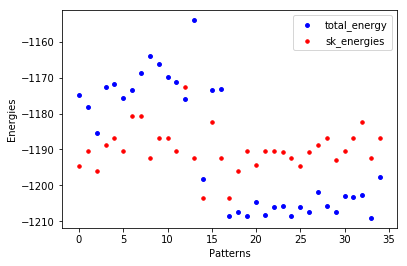

In [21]:
lm = LinearRegression()
lm_exchange_fit = lm.fit(X=model_matrix[["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]], y=model_matrix["total_energy"])
lm_exchange_parameters = pd.DataFrame({
    "sklearn": [lm_exchange_fit.intercept_, 
                lm_exchange_fit.coef_[0], lm_exchange_fit.coef_[1],lm_exchange_fit.coef_[2],
                lm_exchange_fit.coef_[3], lm_exchange_fit.coef_[4],lm_exchange_fit.coef_[5],
                lm_exchange_fit.coef_[6], lm_exchange_fit.coef_[7]]},
    index=["Intercept", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"],
)


sk_par = lm_exchange_parameters.drop(lm_exchange_parameters.index[0])
sk_intercept = lm_exchange_parameters["sklearn"].values[0]

par_table =["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
neighbor_energies = model_matrix[par_table].copy().reset_index(drop=True)

a = neighbor_energies.values 
b = sk_par.transpose().values
sk_energies = np.sum(a*b, axis =1 ) + sk_intercept

energies = pd.DataFrame()
energies["total_energy"] = model_matrix["total_energy"]

energies["sk_energies"] = sk_energies


#features=["total_energy", "ss_energy", "sk_energy"]
x = range(len(energies))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, energies.total_energy, s=15, c='b', label='total_energy')
ax.scatter(x, energies.sk_energies, s=12, c='r', label='sk_energies')
plt.ylabel('Energies')
plt.xlabel('Patterns')
plt.legend();
plt.show()

#### Check the values of energies predicted from the sk_fit parameters vs. the starting values:

In [24]:
#keep original matrix
data = model_matrix.copy()
data.head()


parameters = ["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
energy_predict = pd.DataFrame()
energy_predict["energy_calc"] = data.total_energy 
for i in range(1, 9):
    pars_to_fit = parameters[:i]    
    sk_fit = lm.fit(X=data[pars_to_fit], y=data.total_energy)
    energy_predict[f"energy_{i}"] = sk_fit.predict(data[pars_to_fit])
    
energy_predict.head()

,energy_calc,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8
1,-1174.746731,-1189.392669,-1194.569616,-1195.268270,-1194.590927,-1194.590927,-1194.590927,-1194.590927,-1194.590927
2,-1178.053822,-1192.169906,-1190.170300,-1190.195477,-1190.329263,-1190.329263,-1190.329263,-1190.329263,-1190.329263
3,-1185.449491,-1194.947143,-1197.158572,-1197.087762,-1196.061663,-1196.061663,-1196.061663,-1196.061663,-1196.061663
4,-1172.536486,-1183.838195,-1191.980659,-1191.758789,-1188.774726,-1188.774726,-1188.774726,-1188.774726,-1188.774726
5,-1171.773150,-1186.615432,-1187.581344,-1187.530990,-1186.685795,-1186.685795,-1186.685795,-1186.685795,-1186.685795


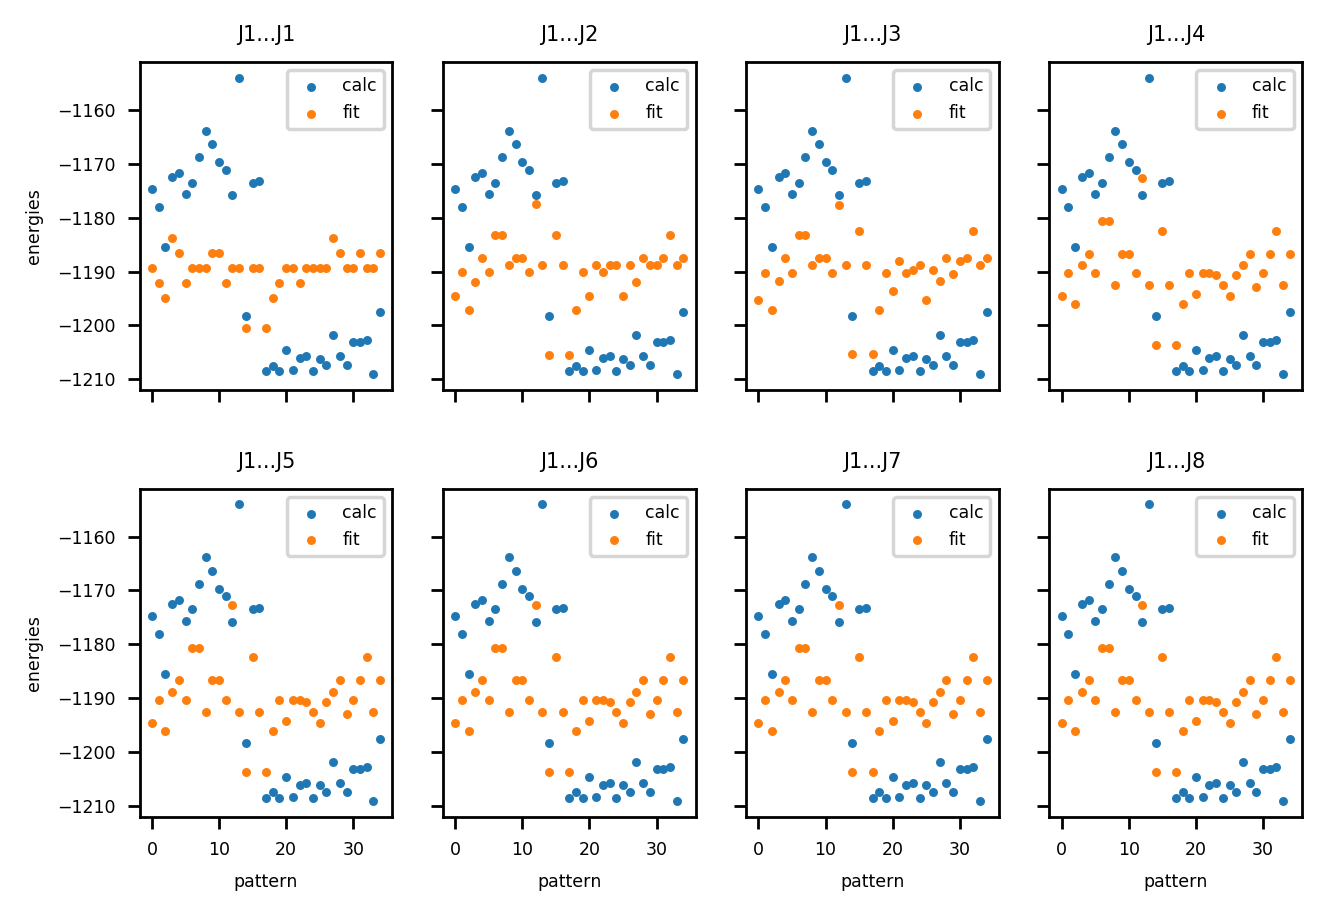

In [25]:
plt.rcParams.update({'font.size': 5})
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', dpi=250)
fig.subplots_adjust(hspace=0.3)
k = 1
for i in range(2):
    for j in range(4):
        p_e = "energy_"+str(k)
        J = "J" + str(1)+"...J"+str(k)
        ax[i, j].scatter(x= range(len(data) ), y="energy_calc", data=energy_predict, label = "calc", s=2.5)
        ax[i, j].scatter(x= range(len(data) ), y=p_e, data=energy_predict, label = "fit", s=2.5)
        ax[i, j].set_title(J)
        ax[i, j].set(xlabel='pattern', ylabel='energies')
        ax[i, j].legend()
        k = k+1
        
for aij in ax.flat:
    aij.label_outer()

#### Repeated k-fold:

In [26]:
#checking for reasonable k
from sklearn.model_selection import KFold
parameters = np.array([1,2,3,4,5,6,7,8])

#for i in range(10):
kfold = KFold(4, True, 1)
# enumerate splits
for train, test in kfold.split(parameters):
    print('train: %s, test: %s' % (parameters[train], parameters[test]))

train: [1 2 4 5 6 7], test: [3 8]
train: [1 3 4 5 6 8], test: [2 7]
train: [2 3 4 6 7 8], test: [1 5]
train: [1 2 3 5 7 8], test: [4 6]


#### Loop over  different number of J parameters, use repeated k-fold cross validation to score the models: k = 4, repeats = 100

In [54]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
lm = LinearRegression()

scores = {
    "n": [],
    "mse_trace": [],
    "mse_mean": [],
    "mse_sd": [],
    "r**2_trace": [],
    "r**2_mean": [],
    "r**2_sd": [],
}

parameters = ["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
energy_predict = pd.DataFrame()
energy_predict["energy_calc"] = data.total_energy 
for n in range(1, 9):
    x = data[parameters[:n]]    
    y = data.total_energy
    
    rkf = RepeatedKFold(
        n_splits=4,
        n_repeats=1000,
        random_state=int(np.round(np.random.uniform(0, 2**31), decimals=0)),
    )
    
    # Cross-validated mean-squared error score
    mse_cv_score = cross_val_score(
        lm,
        x, y,
        scoring="neg_mean_squared_error",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )
    
     # Cross-validated R**2 score
    r2_cv_score = cross_val_score(
        lm,
        x, y,
        scoring="r2",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )
    
    scores["n"].append(n)
    scores["mse_trace"].append(mse_cv_score)
    scores["mse_mean"].append(np.mean(mse_cv_score))
    scores["mse_sd"].append(np.std(mse_cv_score))
    scores["r**2_trace"].append(r2_cv_score)
    scores["r**2_mean"].append(np.mean(r2_cv_score))
    scores["r**2_sd"].append(np.std(r2_cv_score))


##### Model Performance scores

In [55]:
n_par_scores = pd.DataFrame(scores)
n_par_scores[["n", "mse_mean", "mse_sd", "r**2_mean", "r**2_sd"]]

,n,mse_mean,mse_sd,r**2_mean,r**2_sd
0,1,-324.334119,69.692521,-0.311318,2.411464
1,2,-319.923265,80.245509,-0.241905,1.026168
2,3,-349.745734,94.525781,-0.450422,2.842196
3,4,-372.761758,123.520870,-0.503052,3.113197
4,5,-373.695444,125.479157,-0.635415,6.544375
5,6,-375.699232,125.021388,-0.568362,3.702206
6,7,-375.925771,129.806617,-0.469813,1.806295
7,8,-377.416219,133.524833,-0.649959,6.994576


#### Distribution of cross-validation scores 

In [56]:
cv_scores_dist = pd.concat([
          pd.DataFrame(n_par_scores["mse_trace"].tolist())\
          .assign(n=range(1, 9), score = "mse") \
          .melt(id_vars=["n", "score"], 
                value_vars=list(range(400)), var_name="cv_run", value_name="value")\
          .sort_values(["score", "n", "cv_run"]) \
          .reset_index(drop=True),
          pd.DataFrame(n_par_scores["r**2_trace"].tolist())\
          .assign(n=range(1, 9), score = "r**2") \
          .melt(id_vars=["n", "score"], 
                value_vars=list(range(400)), var_name="cv_run", value_name="value")\
          .sort_values(["score", "n", "cv_run"]) \
          .reset_index(drop=True) 
])

mse_scores_dist = cv_scores_dist \
    .query("score == 'mse' & n != '1' ") \
    .loc[:, ["n", "value"]] \
    .rename(columns={"n": "#_of_J"}) \
    .reset_index(drop=True)
    
r2_scores_dist = cv_scores_dist \
    .query("score == 'r**2'  & n != '1'") \
    .loc[:, ["n", "value"]] \
    .rename(columns={"n": "#_of_J"}) \
    .reset_index(drop=True)

#mse_bin= np.linspace(mse_scores_dist.value.min(), mse_scores_dist.value.max(), 20)
#r2_bin = np.linspace(r2_scores_dist.value.min(), r2_scores_dist.value.max(), 20)

 - mean-squared error scores distribution for different numbers of J in calculation:

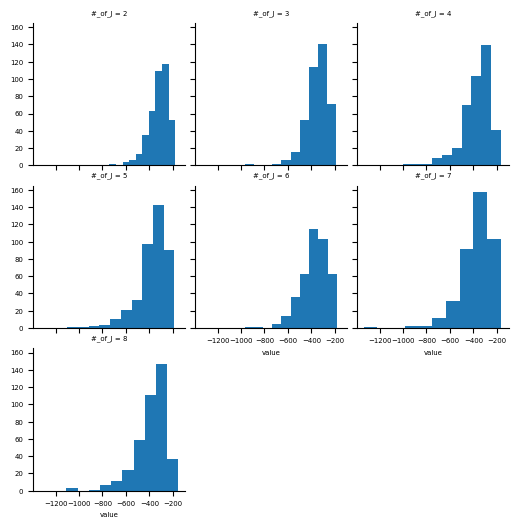

In [57]:
g = sns.FacetGrid(mse_scores_dist, 
                   col = "#_of_J", 
                   col_wrap=3, 
                   sharex=True,
                   sharey=True
                  )
g.map(plt.hist, "value")

g.fig.set_dpi(100)
g.fig.set_size_inches(5, 5);

- $R^2$ scores distribution for different numbers of J in calculation:

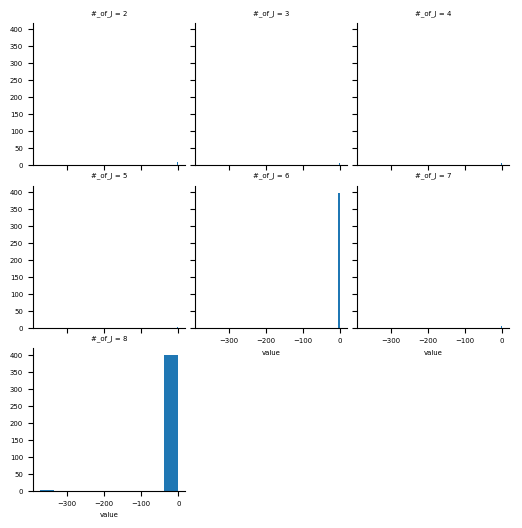

In [58]:
g = sns.FacetGrid(r2_scores_dist, 
                   col = "#_of_J", 
                   col_wrap=3, 
                   sharex=True,
                   sharey=True
                  )
g.map(plt.hist, "value")

g.fig.set_dpi(100)
g.fig.set_size_inches(5, 5);

#### Resampling (bootstrapping) to determine error bars

In [59]:
bootstrap_results = {
    "n": [],
    "sample": [],
    "mean": [],
}

bootstrap_series = cv_scores_dist \
        .query(f"score == 'mse' & n == '{n}'") \
        .sample(frac=1000, replace=True).loc[:, "value"]
bootstrap_df = pd.DataFrame(bootstrap_series)
len(bootstrap_df)      

400000